In [1]:
from neo.io import AxonIO
from scipy.interpolate import UnivariateSpline

from utils import get_filenames, despine_ax
from loaders import LFPRecording

plt.style.use('pcb')

In [2]:
files = sorted(get_filenames('data/base recordings/TTX/', contains='abf'))
files_controls = sorted(get_filenames('data/base recordings/TTX/controls', contains='abf'))

In [3]:
filename = files[6]
sig = 0
reader = AxonIO(filename=filename)
seg = reader.read_segment()
signal = np.array(seg.analogsignals[sig])[:,1]

In [4]:
def round_duration(dur_exact):
    exponent = np.floor(np.log10(dur_exact))
    dec = 10 ** exponent
    return np.round(dur_exact / dec) * dec

def read_file(file):
    rec = LFPRecording.from_abf(file, cutoff=15)
    sig = 0
    reader = AxonIO(filename=file)
    seg = reader.read_segment()
    dt = seg.analogsignals[0].sampling_period.base.item()
    valve = np.array(seg.analogsignals[sig])[:,1]
    tarr = np.arange(len(valve)) * dt
    
    open_ixs = np.argwhere((valve[1:] > 0.15) & (valve[:-1] <= 0.15)).flatten()
    openings = np.array([tarr[:-1][ix] for ix in open_ixs])
    
    close_ixs = np.argwhere((valve[1:] < -0.15) & (valve[:-1] >= -0.15)).flatten()
    closings = np.array([tarr[:-1][ix] for ix in close_ixs])
    
    durations = closings - openings
    
    responses = {}
    
    for i in range(3):
        rd = round_duration(durations[i])
        tarr, varr = rec.segment(openings[i]-1, closings[i]+2).to_arrays()
        
        base_mask = (tarr > openings[i]-1) & (tarr < openings[i]-0.1)
        
        f = UnivariateSpline(tarr-openings[i], varr-varr[base_mask].mean(), s=0, k=1)
        
        xx = np.arange(-1, 4, 0.001)
        responses[rd] = (xx, f(xx))
        
    return responses

Text(0.0, 1.0, 'control')

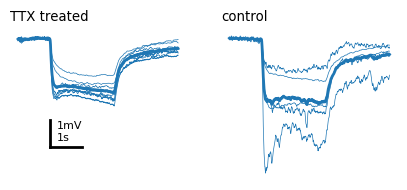

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(5,2), sharey=True)

excluded_lists = [
    [0, 1, 3, 4, 5, 10 ,11, 12, 13, 14, 15, 16],
    [3, 4, 6, 8, 9, 10, 11]
]

for files_list, elist, ax in zip([files, files_controls], excluded_lists, axes):
    pairs = []

    for i, file in enumerate(files_list):#[files[i] for i in [2,6,7,8,9]]:
        if i in elist:
            continue

        recordings = read_file(file)

        pairs.append(recordings[2])

    varrs = np.array([p[1] for p in pairs])
    tarr = pairs[0][0]
    varr_mean = varrs.mean(axis=0)

    for varr in varrs:
        ax.plot(tarr, varr, c='C0', lw=0.5)

    ax.plot(tarr, varr_mean, c='C0', lw=2)

#     ax.set_xlabel('time (s)')
    despine_ax(ax)
    
# axes[0].set_ylabel('LFP (mV)')

axes[0].plot([0,0],[-3,-4], color='black', lw=2)
axes[0].plot([0,1],[-4,-4], color='black', lw=2)
axes[0].text(0.2, -3.75, '1mV\n1s', ha='left')

axes[0].set_title('TTX treated', loc='left')
axes[1].set_title('control', loc='left')

# plt.savefig('img/ttx_full.png')